This notebook illustrates the sensitivity analysis on the number of features

#### Load data set with features

In [1]:
from create_df import read_df
df, dfc, all_homes, appliance_min, national_average = read_df()

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 24 days


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
run all_functions.py

In [4]:
run features.py

In [5]:
appliance_name_map = {"fridge":"Fridge","hvac":"HVAC","wm":"Washing\nmachine",
                      "dr":"Dryer","dw":"Dish\nwasher","light":"Lights"}
import json

#### Finding the  TRAIN ACCURACY

In [6]:
import json
appliances = ["dr","hvac","wm","dw","fridge","light"]
features = ["Static", "Monthly", "Monthly+Static"]
#features=["AMI+Static"]
#features=["All"]
#appliances=["fridge","hvac","dr","dw"]
#features = feature_map.keys()
out={}
means = {}
sems = {}
for feature in features:
    out[feature]={}
    means[feature]={}
    sems[feature]={}
    for appliance in appliances:
    
        out[feature][appliance] = {}
        for home in all_homes[appliance]:
            try:
                j = json.load(open("../main-out-new/%s_%s_%d.json" %(appliance, feature, home),'r'))
                out[feature][appliance][int(home)] = j['accuracy']
            except:
                pass
                                     
                
           
train_df = pd.DataFrame({k:pd.DataFrame(out[k]).mean() for k in features})


In [7]:
train_df

,Monthly,Monthly+Static,Static
dr,27.399581,28.697681,26.140318
dw,21.222768,22.525817,19.941430
fridge,66.048773,68.082701,63.642268
hvac,76.502214,76.081346,68.980325
light,36.843681,36.792903,37.165298
wm,46.280977,47.294136,48.233818


In [8]:
to_use_feature = {}
for appliance in ["dr","hvac","wm","dw","fridge","light"]:
    to_use_feature[appliance] = train_df.ix[appliance].argmax()

#### TEST accuracy of Gemello- needs to choose best amongst static, static+monthly and monthly

In [11]:
from constants import APPROACH as APPROACH_NAME

In [9]:
appliances = ["dr","hvac","wm","dw","fridge","light"]

out={}
means = {}
sems = {}

for appliance in appliances:
    feature=to_use_feature[appliance]
    

    out[appliance] = {}
    for home in all_homes[appliance]:
        try:

            out[appliance][int(home)] = pd.read_csv("../main-out-new/%s_%s_%d.csv" %(appliance, feature, home),
                                 header=None, index_col=0, names=["accuracy"]).squeeze()
        except Exception, e:
            print e


    means[appliance_name_map[appliance]]=pd.DataFrame(out[appliance]).mean().mean()
    sems[appliance_name_map[appliance]]=pd.DataFrame(out[appliance]).mean().sem()          

In [12]:
feature_accuracies = {APPROACH_NAME:means}


In [13]:
feature_accuracies

{'Gemello': {'Dish\nwasher': 27.333401871684234,
  'Dryer': 33.052222078385938,
  'Fridge': 68.541552745826976,
  'HVAC': 76.239355252614146,
  'Lights': 42.757293980395275,
  'Washing\nmachine': 57.272795296939734}}

#### Finding the accuracies on AMI and ALL features

In [14]:
appliances = ["dr","hvac","wm","dw","fridge","light"]
#features = ["Static","Monthly", "Monthly+Static"]
#features=["AMI+Static"]

#features=["All"]
out={}
means = {}
sems = {}

for feature in ["All","AMI"]:
    feature_accuracies[feature] = {}
    for appliance in appliances:
        
    
    

        out[appliance] = {}
        for home in all_homes[appliance]:
            try:

                out[appliance][int(home)] = pd.read_csv("../main-out-new/%s_%s_%d.csv" %(appliance, feature, home),
                                     header=None, index_col=0, names=["accuracy"]).squeeze()
            except Exception, e:
                print e


        means[appliance_name_map[appliance]]=pd.DataFrame(out[appliance]).mean().mean()
        sems[appliance_name_map[appliance]]=pd.DataFrame(out[appliance]).mean().sem()
        feature_accuracies[feature][appliance_name_map[appliance]]=pd.DataFrame(out[appliance]).mean().mean()           

In [15]:
sen=pd.DataFrame(feature_accuracies).T

In [16]:
sen

,Dish washer,Dryer,Fridge,HVAC,Lights,Washing machine
AMI,27.659256,22.777151,73.275673,73.036422,40.015019,49.484331
All,24.638568,25.972393,66.410514,75.154290,36.418069,52.466302
Gemello,27.333402,33.052222,68.541553,76.239355,42.757294,57.272795


#### Adding the ORACLE accuracy

In [17]:
from itertools import combinations
out = {}
for appliance in ["wm","dw","hvac","fridge","light","dr"]:
    out[appliance] = {}
    for home in all_homes[appliance]:
        out[appliance][home] = {"best_prediction_array":{}, "best_score":1e7, "optimal_subset":{}}






appliance_columns = {'fridge':["fridge_%d" % i for i in range(1, 13)],
                     'hvac':["hvac_%d" % i for i in range(1, 13)],
                     "light":["light_%d" % i for i in range(1, 13)],
                     "dw":["dw_%d" % i for i in range(1, 13)],
                     "wm":["wm_%d" % i for i in range(1, 13)],
                     "dr":["dr_%d" % i for i in range(1, 13)]}

errors_dict = {}
for appliance in appliance_columns.keys():
    print appliance
    errors_dict[appliance] = {}
    for max_length in range(1, 3):
        errors_dict[appliance][max_length] = {}
        all_combinations = combinations(all_homes[appliance], max_length)
        for train_homes in all_combinations:

            test_homes = np.setdiff1d(all_homes[appliance],train_homes)
            for home in test_homes:
                pred_home = np.mean(df.ix[list(train_homes)][appliance_columns[appliance]])
                gt_home = df.ix[home][appliance_columns[appliance]]
                if appliance is "hvac":
                    error = np.mean(100*(gt_home-pred_home).abs().div(gt_home)[4:9])
                else:
                    error = np.mean(100*(gt_home-pred_home).abs().div(gt_home))
                if error<out[appliance][home]['best_score']:
                    if appliance is "hvac":
                        errors_dict[appliance][max_length][home] = 100*(gt_home-pred_home).abs().div(gt_home)[4:9]
                    else:
                        errors_dict[appliance][max_length][home] = 100*(gt_home-pred_home).abs().div(gt_home)
                    out[appliance][home]['best_score'] = error
                    out[appliance][home]['optimal_subset'] = train_homes
                    out[appliance][home]['best_prediction_array'] = pred_home


hvac
light
wm
fridge
dw
dr


In [19]:
oracle_accuracy = (100-pd.Series({f:pd.DataFrame(errors_dict[f][2]).mean().mean() for f in appliance_columns.keys()}))

In [23]:
oracle_accuracy.index = [appliance_name_map[x] for x in oracle_accuracy.index]

In [24]:
oracle_accuracy

Dryer               64.885914
Dish\nwasher        61.017474
Fridge              91.888765
HVAC                93.195960
Lights              75.398701
Washing\nmachine    80.183453
dtype: float64

In [25]:
sen.loc['Oracle'] = oracle_accuracy

#### Plotting stuff

In [26]:
from common_functions import latexify, format_axes, tableau20blind

In [27]:
latexify()

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [28]:
sen = sen[['HVAC','Fridge','Washing\nmachine','Lights','Dryer','Dish\nwasher']].T

In [29]:
sen = sen.rename(columns={"All":"All\nfeatures"})

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:856: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


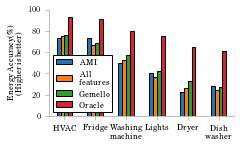

In [30]:
sen.plot(kind="bar",rot=0, colors=tableau20blind[::2])
format_axes(plt.gca())
plt.legend(loc=3)
plt.ylabel("Energy Accuracy(\%)\n(Higher is better)");
plt.tight_layout()
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/sensitivity-features.pdf",bbox_inches="tight")
plt.savefig("/Users/nipunbatra/git/monthly-disaggregation/results/sensitivity-features.png",bbox_inches="tight")

### Answering some other questions about feature importance

Explaining top features from monthly, static, or both

In [38]:
from collections import Counter
import json
out={}

for appliance, feature in to_use_feature.iteritems():
    out[appliance]=Counter()
    for home in all_homes[appliance]:
        try:
            j = json.load(open("../main-out-new/%s_%s_%d.json" %(appliance, feature, home),'r'))
            
            out[appliance].update(j['f'])
        except:
            pass

In [40]:
pd.Series(out['dr'])

aggregate_5           23
aggregate_6           28
aggregate_7           31
area                  32
difference_min_max     9
num_rooms             32
p_75                   4
total_occupants       32
dtype: int64

In [41]:
pd.Series(out['light'])

area               12
num_rooms           3
total_occupants     2
dtype: int64

In [42]:
pd.Series(out['hvac'])

aggregate_10           4
aggregate_5           31
aggregate_6           33
aggregate_7           16
aggregate_8           33
aggregate_9           22
difference_min_max     3
p_75                  31
dtype: int64

In [44]:
pd.Series(out['dw'])

aggregate_1        20
aggregate_10        4
aggregate_11       16
aggregate_12       24
aggregate_5        11
aggregate_6         2
aggregate_7         6
aggregate_8         2
num_rooms           1
total_occupants    13
dtype: int64

For dishwasher, aggregate in December and Jan seems to be an important feature, odd?

In [ ]:
fr = 'aggregate_12'
a = df.ix[all_homes['dw']][[fr,'fridge_5']]
#a = a.query('fridge_7<100')
plt.scatter(a[fr],a['fridge_5'])
#plt.ylim((0, 100))
df.ix[all_homes['fridge']][[fr,'fridge_5']].corr()

In [ ]:
#### For fridge kurtosis isn't a high correlation showing measure, but, 

#### Why fridge improves with AMI?

,kurtosis,fridge_5
kurtosis,1.000000,0.154295
fridge_5,0.154295,1.000000


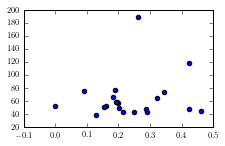

In [185]:
fr = 'kurtosis'
a = df.ix[all_homes['fridge']][[fr,'fridge_5']]
#a = a.query('fridge_7<100')
plt.scatter(a[fr],a['fridge_5'])
#plt.ylim((0, 100))
df.ix[all_homes['fridge']][[fr,'fridge_5']].corr()

In [177]:
o = {}
for f in ['difference_min_max']:
    o[f]={}
    for month in range(1, 13):
        o[f][month] = df.ix[all_homes['fridge']][[f,'fridge_%d' %month]].corr().values[0, 1]
    

In [178]:
pd.DataFrame(o).mean()

difference_min_max    0.022031
dtype: float64

In [175]:
from collections import Counter
import json
appliance="fridge"
feature="Monthly"
out={}
means = {}
sems = {}

c=Counter()
for home in all_homes[appliance]:
    try:
        j = json.load(open("../main-out-new/%s_%s_%d.json" %(appliance, feature, home),'r'))

        c.update(j['f'])
    except:
        pass
                                     
                
           


In [176]:
pd.Series(c)

aggregate_10                 1
aggregate_11                 4
aggregate_4                 15
aggregate_5                 10
aggregate_6                  4
aggregate_9                  6
difference_min_max          20
kurtosis                     8
p_50                         2
p_75                         5
ratio_difference_min_max     8
ratio_min_max                4
dtype: int64

In [ ]:
df